# Algorytmy uczenia maszynowego - projekt 

## Sprawozdanie 

Wykonał - Stanisław Felczyński 247366 \
Prowadzący - Mgr inż. Marcin Ochman 

Proste algorytmy uczenia maszynowego w grze kółko i krzyżyk. 

Celem projektu jest użycie trzech popularnych algorytmów uczenia maszynowego 
w celu stworzenia programów grających w kółko i krzyżyk, na planszy o stałym rozmiarze 
6x6 oraz wymagającej symboli w rzezie do wygranej. 

Użyte algotytmy to Q-table, SVM oraz prosta sieć neuronowa. Poniżej znajduje się opi tych algorytmów 
oraz graczy, jak również kilku nie uczących się graczy.

## Q-table 

Najpierw tworzymy obiekt składający się z tablic z liczbami, które definiują prawdopodobieństwo
wybranania danego ruchu w danej pozycji. 
Dla każdego stanu w którym znajduje się obiekt (w tym wypadku dla każdego napotkanego układu x i o)
zapisujemy wykonany ruch. Po rozstrzygnięciu gry aktualizujemy wykonanym ruchom wartości - odejmujemy 
gdy gra jest przegrana i vice versa. 
W ten sposób, gdy algorytm napotka ten sam stan po raz drugi, jest mniej prawdopodobne że powtórzy 
ruch z gry przegranej i vice versa. 

Ze względu na bardzo dużą liczbę możliwych kombinacji i rzadkość ich powtarzania(zależy od algorytmu)
gracz oparty na tym algorytmie radzi sobie bardzo słabo z nieprzewidywalnymi graczami, ale całkiem w
porządku z graczami przewidywalnymi.

## SVM 

Ten algorytm w ogóle nie nadaje się do tego zastosowania. Jest to typowy klasyfikator - dajemy mu 
jakąś przestrzeń wypełnioną punktami zakfalifikowanymi do iluś kategorii, a on daje nam równania 
dzielące całą przestzeń na obszary, co pozwala nam zkasyfikować dowolny nowy punkt w tej przestzeni. 
Można by zastosować podejście podobne jak Q-table, czyli najpierw ocenić n ruchów w różnych stanach planszy
innym algorytmem (który swoją drogą byłby o wiele lepszym graczem) a potem podzielić tą ogromną i rzadko 
zaludnioną przestzeń wszystkich możliwych ruchów we wszystkich możliwych stanach. 

Wydaje mi się to prywatnie słabym pomysłem, a algorytm oceniający ruch byłby najbardziej skomplikowaną 
częścią jego działania, nie mając wiele wspólnego z uczeniem maszynowym.

Zamiast tego wykonałem też mizerne rozwiązanie, w którym SVM dzieli przestrzeń możliwych stanów 
(wciąż dosyć niestandardową, ale przynajmniej mniejszą) i na podstawie girozegranych gier dzieli 
ją na gry wygrane oraz przegrane. Potem wykonuje losowy ruch który według niego znajduje się po części wygranej.
Nie działa to zbyt dobrze, ale są ładne wykresiki z tego jak się uczy rozdzielać przestrzeń, także uważam to za sukces. 

## Sieć neuronowa 

Prosta 4 warstwowa (razem z wejściem i wyjściem) sieć neronowa, która stara się tak dobrać współczynniki żeby wygrać lub zremisować grę. 
Ponieważ w trakcie gry nie zna ona wyniku, działa podobnie jak Q-table (nazywa się to zjandowanie q-value), czyli aktualizuje się już po grze na podstawie wykonanych w trakcie ruchów. 

## Random 

Wykonuje przypadkowy ruch.

## Score i ScoreV2 

Wykonują ruch który zwiększa ile w rzędzie mają symboli swoich. 

In [2]:
# wszystkie paczki/moduły/funkcje które będą potrzebne
from board import (play_games, play_games_more_stats, play_random_move, play_middle_move, play_score_move, play_scoreV2_move, play_showcase, play_test_game, play_human_game, Board)
from qtable import (qtables, play_training_qtable_games_x, play_training_qtable_games_o, create_q_table_player)
from SVM import (play_training_SVM_games, test_SVM_accuracy, create_SVM_player, SVM)
from NN import (TicTacNet, NetContext, create_qneural_player, get_q_values, play_training_games_x, play_training_games_o)
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from torch.nn import MSELoss    


---------------
  0 1 2 3 4 5 
0|-|-|X|-|-|-|
1|-|-|X|-|-|-|
2|-|-|X|O|-|-|
3|-|-|X|O|-|-|
4|-|-|-|O|-|-|
5|-|-|-|-|-|-|
---------------
Last move was: (0, 2)
X wins!

-----------

X wins: 72.00%
O wins: 28.00%
draws:  0.00%
Average moves played in game:  9.36
Average time of game:  12.34 ms
Average time of move:  1.318 ms


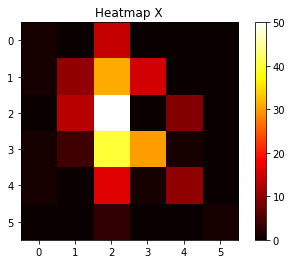

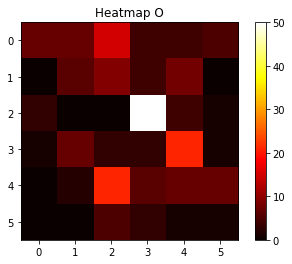

In [2]:
# testowanie czy działa granie
play_test_game (play_score_move,play_scoreV2_move)
st = play_games_more_stats(50, play_score_move, play_scoreV2_move, print_stats = True)

10.0 % Treningu skończone. Zajęło  50.04673194885254  s
20.0 % Treningu skończone. Zajęło  100.51438164710999  s
30.0 % Treningu skończone. Zajęło  151.66944098472595  s
40.0 % Treningu skończone. Zajęło  203.59657168388367  s
50.0 % Treningu skończone. Zajęło  255.2039806842804  s
60.0 % Treningu skończone. Zajęło  308.16493463516235  s
70.0 % Treningu skończone. Zajęło  359.92793822288513  s
80.0 % Treningu skończone. Zajęło  412.9557809829712  s
90.0 % Treningu skończone. Zajęło  466.9725959300995  s
100.0 % Treningu skończone. Zajęło  519.8736364841461  s


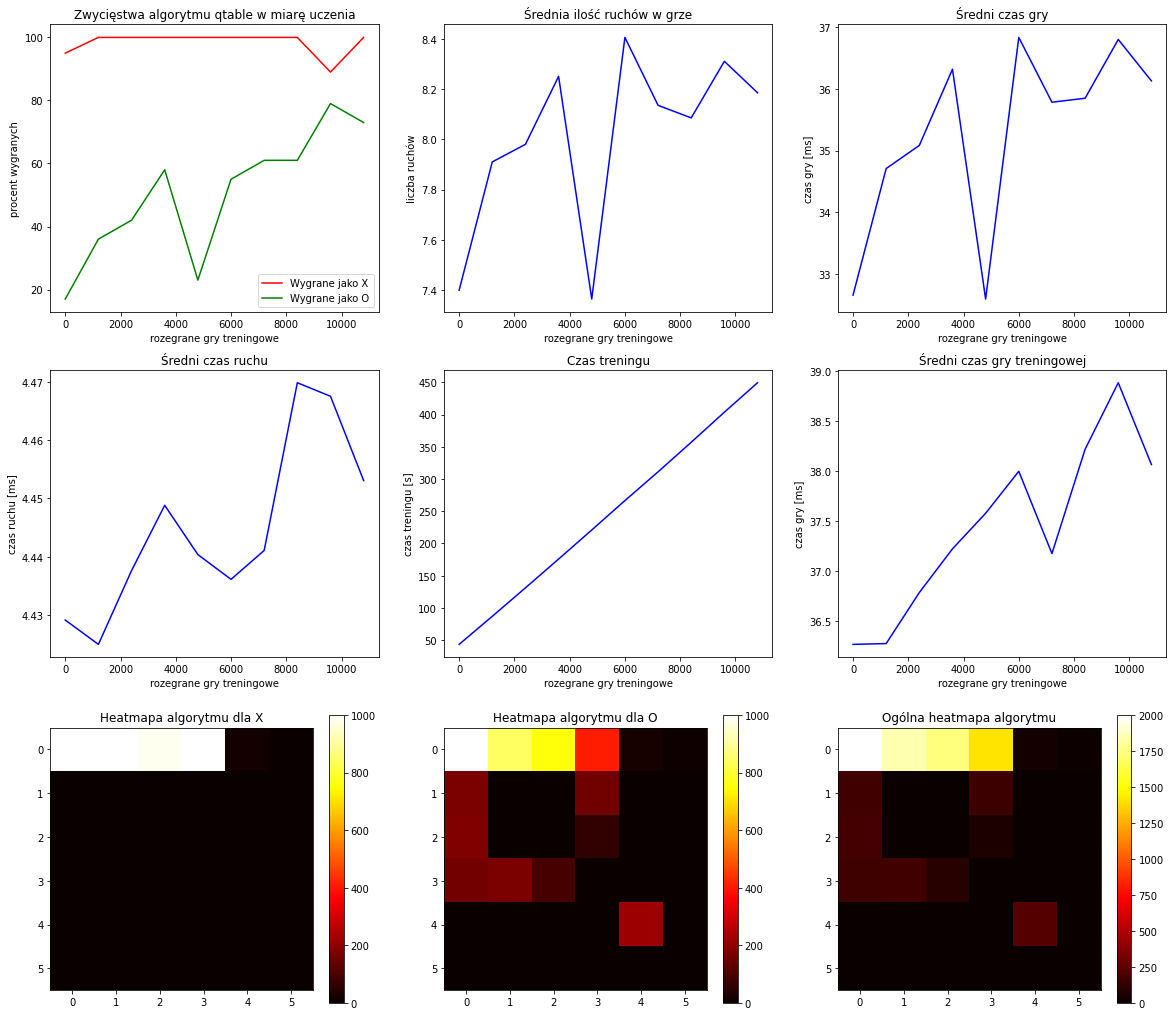

In [3]:
# uczenie i testowanie algorytmu q_table 

ucz_w_serii = 1000
test_w_serii = 100
liczba_serii = 10
stata = np.zeros([liczba_serii,10])
mapa_x = np.zeros(36,int)
mapa_o = np.zeros(36,int)
mapa = np.zeros(36,int)
training_time = 0

for i in range (liczba_serii):
    # print("Training qtable X vs. score...")
    start_time = time.time()
    play_training_qtable_games_x(total_games = ucz_w_serii, q_tables=qtables,
                          o_strategies=[play_scoreV2_move])
    # print("Training qtable O vs. score...")
    play_training_qtable_games_o(total_games = ucz_w_serii, q_tables=qtables,
                          x_strategies=[play_scoreV2_move])
    # print("")
    elapsed_time = time.time()- start_time
    stata[i,0] = 2*i*ucz_w_serii
    stata[i,8] = stata[i-1,8] + elapsed_time # czas nauki
    stata[i,9] = 1000*elapsed_time/(2*ucz_w_serii) # śr czas nauki na grę
    
    play_q_table_move = create_q_table_player(qtables)
    # print("Playing qtable vs score:")
    # print("-------------------------")
    st = play_games_more_stats(test_w_serii, play_q_table_move, play_scoreV2_move)
    stata[i,1] = st[0] # wygrane X
    stata[i,2] = st[2] # remisy
    stata[i,5] = st[3] # ruchy na grę
    stata[i,6] = st[4] # czas na grę
    stata[i,7] = st[5] # czas na ruch
    mapa_x = mapa_x + st[6]
    # print("")

    play_q_table_move = create_q_table_player(qtables)
    # print("Playing score vs qtable:")
    # print("-------------------------")
    st = play_games_more_stats(test_w_serii, play_scoreV2_move, play_q_table_move)
    stata[i,3] = st[1] # wygrane O
    stata[i,4] = st[2] # remisy
    stata[i,5] = (st[3] + stata[i,5])/2 # ruchy na grę
    stata[i,6] = (st[4] + stata[i,6])/2 # czas na grę
    stata[i,7] = (st[5] + stata[i,7])/2 # czas na ruch
    mapa_o = mapa_o + st[7]
    # print("") 
    
    training_time = training_time + time.time()- start_time
    print(100*(i+1)/liczba_serii,"% Treningu skończone. Zajęło ",training_time," s")
    
mapa = mapa_x + mapa_o    
mapa_x_ksztalt = mapa_x.reshape([6,6])
mapa_o_ksztalt = mapa_o.reshape([6,6])
mapa_ksztalt = mapa.reshape([6,6])

fig, axes = plt.subplots(3, 3, figsize=(20, 18))

axes[0,0].plot(stata[:,0],stata[:,1], 'r-', label="Wygrane jako X")
axes[0,0].plot(stata[:,0],stata[:,3], 'g-', label="Wygrane jako O")
axes[0,0].set_title("Zwycięstwa algorytmu qtable w miarę uczenia")
axes[0,0].set_ylabel("procent wygranych")
axes[0,0].set_xlabel("rozegrane gry treningowe")
axes[0,0].legend(loc = "best")

axes[0,1].plot(stata[:,0],stata[:,5], 'b-')
axes[0,1].set_title("Średnia ilość ruchów w grze")
axes[0,1].set_ylabel("liczba ruchów")
axes[0,1].set_xlabel("rozegrane gry treningowe")

axes[0,2].plot(stata[:,0],stata[:,6], 'b-')
axes[0,2].set_title("Średni czas gry")
axes[0,2].set_ylabel("czas gry [ms]")
axes[0,2].set_xlabel("rozegrane gry treningowe")

axes[1,0].plot(stata[:,0],stata[:,7], 'b-')
axes[1,0].set_title("Średni czas ruchu")
axes[1,0].set_ylabel("czas ruchu [ms]")
axes[1,0].set_xlabel("rozegrane gry treningowe")

axes[1,1].plot(stata[:,0],stata[:,8], 'b-')
axes[1,1].set_title("Czas treningu")
axes[1,1].set_ylabel("czas treningu [s]")
axes[1,1].set_xlabel("rozegrane gry treningowe")

axes[1,2].plot(stata[:,0],stata[:,9], 'b-')
axes[1,2].set_title("Średni czas gry treningowej")
axes[1,2].set_ylabel("czas gry [ms]")
axes[1,2].set_xlabel("rozegrane gry treningowe")

pcm = axes[2,0].imshow(mapa_x_ksztalt, cmap='hot', interpolation='nearest')
axes[2,0].set_title("Heatmapa algorytmu dla X")
fig.colorbar(pcm, ax=axes[2,0])

pcm = axes[2,1].imshow(mapa_o_ksztalt, cmap='hot', interpolation='nearest')
axes[2,1].set_title("Heatmapa algorytmu dla O")
fig.colorbar(pcm, ax=axes[2,1])

pcm = axes[2,2].imshow(mapa_ksztalt, cmap='hot', interpolation='nearest')
axes[2,2].set_title("Ogólna heatmapa algorytmu")
fig.colorbar(pcm, ax=axes[2,2])

plt.show()


training games  0.0 % comlete. It took  0.0 s
training games  10.0 % comlete. It took  5.1828131675720215 s
training games  20.0 % comlete. It took  15.533639907836914 s
training games  30.0 % comlete. It took  31.07351517677307 s
training games  40.0 % comlete. It took  51.839632987976074 s
training games  50.0 % comlete. It took  77.90976071357727 s
training games  60.0 % comlete. It took  109.15970635414124 s
training games  70.0 % comlete. It took  145.60145449638367 s
training games  80.0 % comlete. It took  187.2632179260254 s
training games  90.0 % comlete. It took  234.11426663398743 s
plotting learning curves - might take a while



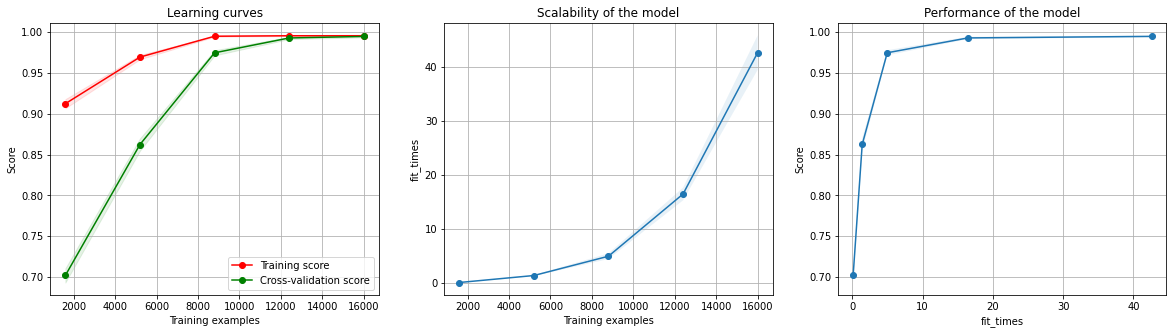

Trening i wykreślenie krzywych uczenia zajęło:  1554.38 s 
Jest to ok:  0.078 s na grę
accuracy =  99.1 %

-----------

X wins: 52.10%
O wins: 47.30%
draws:  0.60%
Average moves played in game:  23.1
Average time of game:  377.65 ms
Average time of move:  16.348 ms


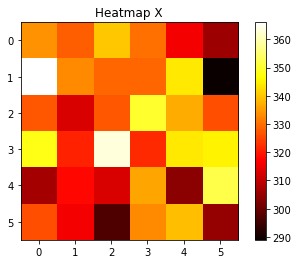

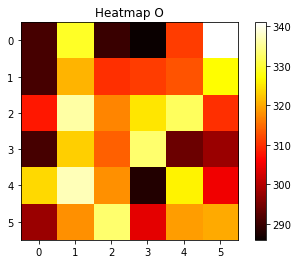

In [2]:
# uczenie i testowanie algorytmu poartego na SVM

gry_treningowe = 20000
gry_test_dokladnosci = 1000
gry_test_algorytmu = 1000

new_model1 = SVM()
start_time = time.time()
play_training_SVM_games(new_model1, gry_treningowe, play_random_move, play_random_move, plot = True)
elapsed_time = time.time() - start_time 
print("Trening i wykreślenie krzywych uczenia zajęło: ", round(elapsed_time,2),"s ")
print("Jest to ok: ", round(elapsed_time/gry_treningowe,3),"s na grę")

test_SVM_accuracy(new_model1, gry_test_dokladnosci, play_random_move, play_random_move)

play_SVMm_move = create_SVM_player(new_model1)
st = play_games_more_stats(gry_test_algorytmu, play_SVMm_move, play_random_move, print_stats = True)

10.0 % Treningu skończone. Zajęło  128.72773003578186  s
20.0 % Treningu skończone. Zajęło  259.6262617111206  s
30.0 % Treningu skończone. Zajęło  402.6134362220764  s
40.0 % Treningu skończone. Zajęło  541.8222315311432  s
50.0 % Treningu skończone. Zajęło  686.6728675365448  s
60.0 % Treningu skończone. Zajęło  834.1125645637512  s
70.0 % Treningu skończone. Zajęło  971.5524644851685  s
80.0 % Treningu skończone. Zajęło  1107.3373816013336  s
90.0 % Treningu skończone. Zajęło  1243.50634932518  s
100.0 % Treningu skończone. Zajęło  1385.031981229782  s


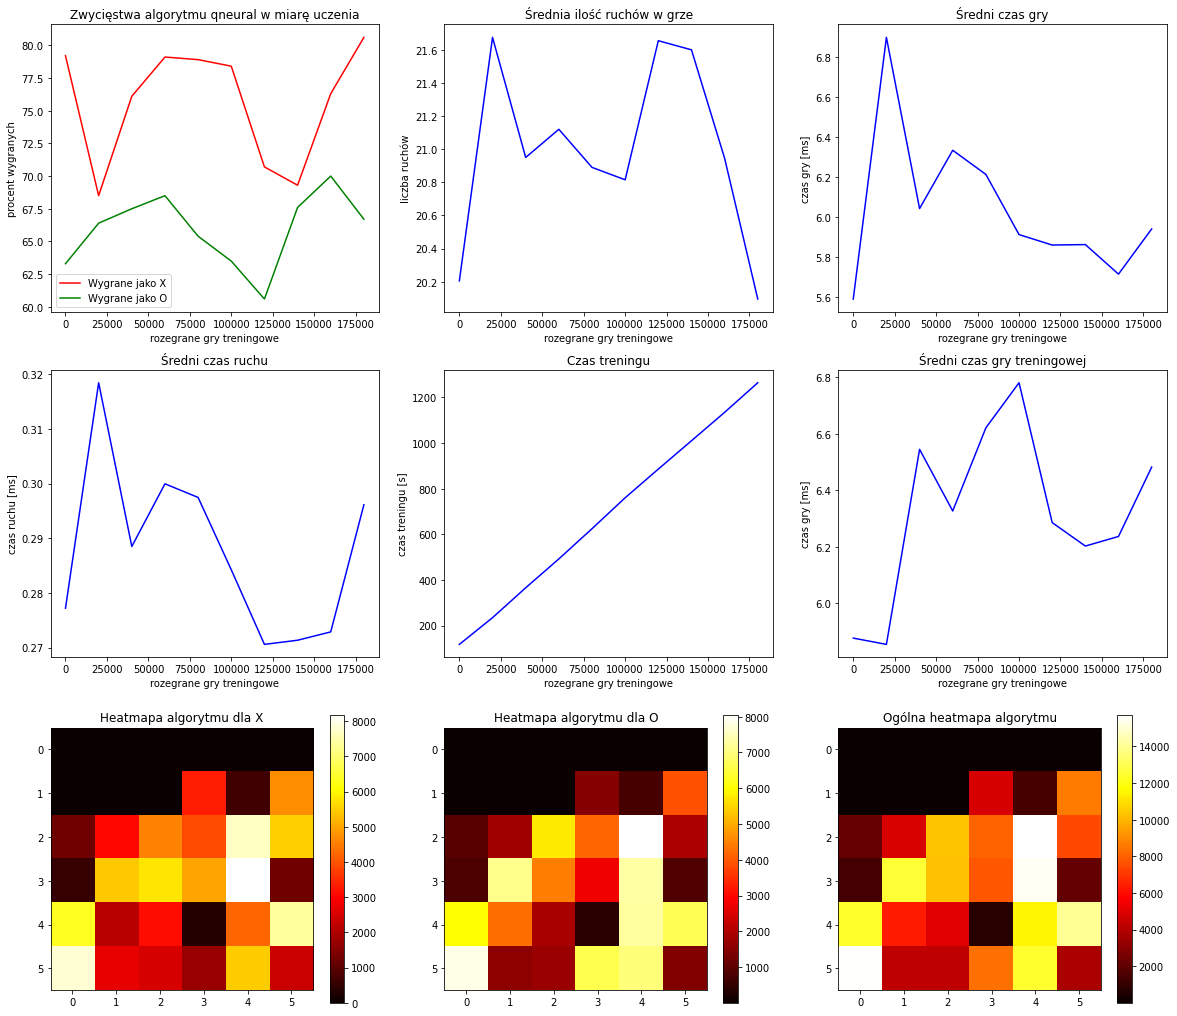

In [4]:
# uczenie i testowanie algorytmu qneural

ucz_w_serii = 10000
test_w_serii = 1000
liczba_serii = 10
stata = np.zeros([liczba_serii,10])
mapa_x = np.zeros(36,int)
mapa_o = np.zeros(36,int)
mapa = np.zeros(36,int)
training_time = 0

policy_net = TicTacNet()
target_net = TicTacNet()
sgd = torch.optim.SGD(policy_net.parameters(), lr=0.1)
# milestones = [20000]
# scheduler = torch.optim.lr_scheduler.MultiStepLR(sgd, milestones, gamma=0.1)
# lambda1 = lambda epoch: 0.999 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(sgd, lr_lambda=lambda1, min_lr = 0.01)
loss = MSELoss()
net_context = NetContext(policy_net, target_net, sgd, loss)

for i in range (liczba_serii):
    # print("Training qtable X vs. score...")
    start_time = time.time()
    play_training_games_x(net_context=net_context, total_games=ucz_w_serii,
                          o_strategies=[play_random_move])
    # print("Training qtable O vs. score...")
    play_training_games_x(net_context=net_context, total_games=ucz_w_serii,
                          o_strategies=[play_random_move])
    # print("")
    elapsed_time = time.time()- start_time
    stata[i,0] = 2*i*ucz_w_serii
    stata[i,8] = stata[i-1,8] + elapsed_time # czas nauki
    stata[i,9] = 1000*elapsed_time/(2*ucz_w_serii) # śr czas nauki na grę
    
    play_qneural_move = create_qneural_player(net_context)
    # print("Playing qtable vs score:")
    # print("-------------------------")
    st = play_games_more_stats(test_w_serii, play_qneural_move, play_random_move)
    stata[i,1] = st[0] # wygrane X
    stata[i,2] = st[2] # remisy
    stata[i,5] = st[3] # ruchy na grę
    stata[i,6] = st[4] # czas na grę
    stata[i,7] = st[5] # czas na ruch
    mapa_x = mapa_x + st[6]
    # print("")

    play_qneural_move = create_qneural_player(net_context)
    # print("Playing score vs qtable:")
    # print("-------------------------")
    st = play_games_more_stats(test_w_serii, play_random_move, play_qneural_move)
    stata[i,3] = st[1] # wygrane O
    stata[i,4] = st[2] # remisy
    stata[i,5] = (st[3] + stata[i,5])/2 # ruchy na grę
    stata[i,6] = (st[4] + stata[i,6])/2 # czas na grę
    stata[i,7] = (st[5] + stata[i,7])/2 # czas na ruch
    mapa_o = mapa_o + st[7]
    # print("") 
    
    training_time = training_time + time.time()- start_time
    print(100*(i+1)/liczba_serii,"% Treningu skończone. Zajęło ",training_time," s")
    
mapa = mapa_x + mapa_o    
mapa_x_ksztalt = mapa_x.reshape([6,6])
mapa_o_ksztalt = mapa_o.reshape([6,6])
mapa_ksztalt = mapa.reshape([6,6])

fig, axes = plt.subplots(3, 3, figsize=(20, 18))

axes[0,0].plot(stata[:,0],stata[:,1], 'r-', label="Wygrane jako X")
axes[0,0].plot(stata[:,0],stata[:,3], 'g-', label="Wygrane jako O")
axes[0,0].set_title("Zwycięstwa algorytmu qneural w miarę uczenia")
axes[0,0].set_ylabel("procent wygranych")
axes[0,0].set_xlabel("rozegrane gry treningowe")
axes[0,0].legend(loc = "best")

axes[0,1].plot(stata[:,0],stata[:,5], 'b-')
axes[0,1].set_title("Średnia ilość ruchów w grze")
axes[0,1].set_ylabel("liczba ruchów")
axes[0,1].set_xlabel("rozegrane gry treningowe")

axes[0,2].plot(stata[:,0],stata[:,6], 'b-')
axes[0,2].set_title("Średni czas gry")
axes[0,2].set_ylabel("czas gry [ms]")
axes[0,2].set_xlabel("rozegrane gry treningowe")

axes[1,0].plot(stata[:,0],stata[:,7], 'b-')
axes[1,0].set_title("Średni czas ruchu")
axes[1,0].set_ylabel("czas ruchu [ms]")
axes[1,0].set_xlabel("rozegrane gry treningowe")

axes[1,1].plot(stata[:,0],stata[:,8], 'b-')
axes[1,1].set_title("Czas treningu")
axes[1,1].set_ylabel("czas treningu [s]")
axes[1,1].set_xlabel("rozegrane gry treningowe")

axes[1,2].plot(stata[:,0],stata[:,9], 'b-')
axes[1,2].set_title("Średni czas gry treningowej")
axes[1,2].set_ylabel("czas gry [ms]")
axes[1,2].set_xlabel("rozegrane gry treningowe")

pcm = axes[2,0].imshow(mapa_x_ksztalt, cmap='hot', interpolation='nearest')
axes[2,0].set_title("Heatmapa algorytmu dla X")
fig.colorbar(pcm, ax=axes[2,0])

pcm = axes[2,1].imshow(mapa_o_ksztalt, cmap='hot', interpolation='nearest')
axes[2,1].set_title("Heatmapa algorytmu dla O")
fig.colorbar(pcm, ax=axes[2,1])

pcm = axes[2,2].imshow(mapa_ksztalt, cmap='hot', interpolation='nearest')
axes[2,2].set_title("Ogólna heatmapa algorytmu")
fig.colorbar(pcm, ax=axes[2,2])

plt.show()

# Wnioski 

Wszystkie wykonane algorytmy graczy oparte na uczeniu maszynowym są beznadziejne. 

Q table potrafi dostosować się do konkretnego przewidywalnego gracza, ale wystrczy postawić znak w dowolnym przypadkowym miejscu i już nie ma pojęcia co robić. 
Jedyną jego zaletą jest to, że gdy nie wie co zrobić to stawia swój znak w polu z najmniejszym indeksem, co jest dobrą strategią przeciwko graczowi przypadkowemu.

SVM był porażką od samego początku. 

Q neural niestety też zawiódł. W podobnym projekcie również używającym paczki torch, portrzeba było 2.000.000 gier treningowych 3x3 żeby algorytm nauczył się grać. 
Wszystkich możliwych gier 3x3 (biarąc pod uwagę symetrie) jest 255 tysięcy, więc każdą z nich odwiedza ok. 10 razy zanim się nauczy. 
Gier 6x6 jest ok. 10^41. \
Różne ustawienia współczynnika uczenia, czy liczby i liczebności warstw nie pomogły algorytmowi nauczyć się lepiej. Żeby był on zdatny do użycia trzeba by albo zastosować głęboką sieć neronową i dać jej kilka dni na naukę, lub połączyć go z innym nie uczącym się algorytmem (np score).

Podsumowując, uczenie maszynowe w grach to zagadnienie o wiele trudniejsze niż się spodziewałem gdy wybierałem ten temat. Nic dziwnego że jeszcze kilka lat temu w szachach to Stockfish był najlepszym algorytmem, choć przecież uczenie maszynowe jest znane i rozwijane od wielu lat. 

## help

Można sobie zagrać samemu z aglorytmem, albo ustawić żeby sobie grały ze sobą. 

funkcje grania: 

`play_games(total_games, x_strategy, o_strategy, play_single_game=play_game)` - Wykonuje `total_games` gier i wyświetla wyniki \
`play_games_more_stats(total_games, x_strategy, o_strategy, play_single_game=play_game, print_stats = False)` - Wykonuje `total_games` gier, zwraca wyniki i kilka statystyk oraz hetamapy. Jeżeli `print_stats = True`, to również wyświetla statystyki w konsoli \
`play_game(x_strategy, o_strategy)` - gra grę
`play_test_game(x_strategy, o_strategy)` - gra grę, wyświetla stan końcowy(planszę po ostatnim ruchu) i wynik \
`play_showcase(x_strategy, o_strategy)` - gra grę i wyświetla planszę po każdym kolejnym ruchu \
`play_human_game(human_move, AI_strategy)` - gra człowiek vs maszyna! `human_move = 1` żeby grać krzyżykiem (zaczynać) i `human_move = -1` żeby grać kółkiem (drógi ruch)

dostępni gracze: 

graczy należy wpisać do funkcji grania w miejsca `x_staregy` i `o_staregy`, lub `AI_strategy`, np. \
`play_showcase(play_qneural_move, play_score_move)`

`play_random_move` - gracz przypadkowy \
`play_middle_move` - gracz środkowy (stawia jak najnliżej środka) \
`play_score_move` - gracz zwiększający wynik \
`play_scoreV2_move` - gracz zwiększający wynik ale trochę inaczej \
`play_q_table_move` - gracz oparty na algorytmie q table \
`play_SVMm_move` - gracz oparty na algorytmie SVM - (w praktyce random) \
`play_qneural_move` - gracz oparty na algorytmie sieci neuronowej q neural

oczywiście żeby grać z algorytmami uczącymi się trzeba je najpierw nauczyć - co chwilę zajmuje niestety

In [5]:
play_showcase(play_qneural_move, play_score_move)


---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|-|-|-|-|
3|-|-|-|-|-|-|
4|-|-|-|-|-|-|
5|-|-|-|-|-|-|
---------------
Last move was: None

---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|-|-|-|-|
3|-|-|-|-|-|-|
4|-|-|-|-|-|-|
5|-|-|-|-|-|X|
---------------
Last move was: (5, 5)

---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|O|-|-|-|
3|-|-|-|-|-|-|
4|-|-|-|-|-|-|
5|-|-|-|-|-|X|
---------------
Last move was: (2, 2)

---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|O|-|-|-|
3|-|-|-|-|-|-|
4|-|-|-|-|-|-|
5|-|-|-|-|X|X|
---------------
Last move was: (5, 4)

---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|O|-|-|-|
3|-|-|-|-|-|-|
4|-|-|-|-|O|-|
5|-|-|-|-|X|X|
---------------
Last move was: (4, 4)

---------------
  0 1 2 3 4 5 
0|-|-|-|-|-|-|
1|-|-|-|-|-|-|
2|-|-|O|-|-|-|
3|X|-|-|-|-|-|
4|-|-|-|-|O|-|
5|-|-|-|-|X|X|
---------------
Last move was: (3, 0)

---------------
  0 1 2 3 4 5 
0|-|-|-|-|